<a href="https://colab.research.google.com/github/swapniel99/ezio/blob/super_conv/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Oct  6 09:42:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/swapniel99/ezio.git

Cloning into 'ezio'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (258/258), done.
remote: Total 310 (delta 114), reused 163 (delta 36), pack-reused 0
Receiving objects: 100% (310/310), 7.76 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [ ]:
%cd ezio

/content/ezio


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np

!pip install torchsummary
from torchsummary import summary

from ezio.data import dataset 
from ezio.data.data_transforms.session_9 import transformations
from ezio.runner import engine
from ezio.utils import loss, lr_finder
from ezio.utils.misclassified_images import misclassified_images

In [ ]:
!pip install albumentations

     |████████████████████████████████| 634kB 5.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654021 sha256=e112587054ea2998b47cd42f84bc59a02113c0035e5ebcd63d251ef783fc6bf8
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
train_transforms = transformations.perform_transformations(train=True, is_numpy=True)
test_transforms = transformations.perform_transformations(train=False, is_numpy=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
train_set, valid_set = dataset.cifar10_dataset(train_transforms, test_transforms)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified


In [ ]:
train_loader, valid_loader = dataset.create_loaders(train_set, valid_set, train_batch_size=32, valid_batch_size=32, num_workers=4)

In [ ]:
from ezio.model.session_9.model import ResNet18
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()

    self.preplayer = nn.Sequential(
        nn.ConvdD(3, 64, 3, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.x1 = nn.Sequential(
        nn.Conv2d(64, 128, 3, padding = 1, bias = False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.r1 = nn.Sequential(
        nn.Conv2d(128, 128, 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(128, 256, 3, padding = 1, bias = False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.x2 = nn.Sequential(
        nn.Conv2d(256, 512, 3, padding = 1, bias = False),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.r2 = nn.Sequential(
        nn.Conv2d(512, 512,3, padding = 1, bias= False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding = 1, bias =- False),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.maxpool = nn.MaxPool2d(4)

    self.fc = nn.Linear(512, 10, bias = False)


  def forward(self):
    preplayer = self.preplayer(x)
    x1 = self.x1(preplayer)
    R1 = self.R1(x1)
    layer1 = x1+R1
    layer2 = self.layer2(layer1)
    x2 = self.x2(layer2)
    R2 = self.R2(x2)
    layer3 = R2+x2
    maxpool = self.pool(layer3)
    x = maxpool.view(maxpool.size(0),-1)
    fc = self.fc(x)

In [ ]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder Module

In [ ]:
model = ResNet18().to(device)
criterion = loss.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7)
lrf = lr_finder.LRFinder(model, optimizer, criterion, device="cuda")
lrf.range_test(train_loader, end_lr=1, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.53E-02


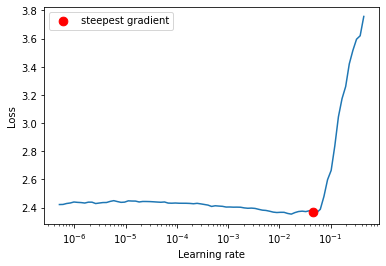

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5b33721c88>,
 0.04534878508128581)

In [ ]:
lrf.plot()

## SGD Optimizer with momentum = 0.9

## ReduceLROnPlateau with patience = 0

In [ ]:
model = ResNet18().to(device)
loss_function = loss.cross_entropy_loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True, factor=0.5)

In [ ]:
train_acc, train_losses, test_acc, test_losses = engine.fit(model, train_loader, valid_loader, loss_function, device, optimizer, 50, scheduler)

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.8305643796920776 Batch_id=1562 Accuracy=30.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.91it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 4366/10000 (43.66%)

EPOCH: 2


Loss=1.8761109113693237 Batch_id=1562 Accuracy=43.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.02it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 5182/10000 (51.82%)

EPOCH: 3


Loss=1.2285653352737427 Batch_id=1562 Accuracy=51.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.07it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 6066/10000 (60.66%)

EPOCH: 4


Loss=0.8930450081825256 Batch_id=1562 Accuracy=57.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.98it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 6741/10000 (67.41%)

EPOCH: 5


Loss=1.4307008981704712 Batch_id=1562 Accuracy=61.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.37it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 6968/10000 (69.68%)

EPOCH: 6


Loss=1.0617151260375977 Batch_id=1562 Accuracy=65.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.40it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 7315/10000 (73.15%)

EPOCH: 7


Loss=0.6775298118591309 Batch_id=1562 Accuracy=69.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.52it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 7741/10000 (77.41%)

EPOCH: 8


Loss=1.6829276084899902 Batch_id=1562 Accuracy=71.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.43it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 7864/10000 (78.64%)

EPOCH: 9


Loss=0.6531261801719666 Batch_id=1562 Accuracy=73.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.32it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 8141/10000 (81.41%)

EPOCH: 10


Loss=0.39965686202049255 Batch_id=1562 Accuracy=75.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.07it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 8042/10000 (80.42%)

Epoch    10: reducing learning rate of group 0 to 2.2500e-02.
EPOCH: 11


Loss=0.8182162046432495 Batch_id=1562 Accuracy=79.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.25it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 8275/10000 (82.75%)

EPOCH: 12


Loss=0.8061428070068359 Batch_id=1562 Accuracy=80.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.10it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 8438/10000 (84.38%)

EPOCH: 13


Loss=0.3769969046115875 Batch_id=1562 Accuracy=81.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.02it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 8526/10000 (85.26%)

EPOCH: 14


Loss=0.5179481506347656 Batch_id=1562 Accuracy=82.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.89it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 8450/10000 (84.50%)

Epoch    14: reducing learning rate of group 0 to 1.1250e-02.
EPOCH: 15


Loss=0.3307971656322479 Batch_id=1562 Accuracy=84.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.84it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 8687/10000 (86.87%)

EPOCH: 16


Loss=0.9214931726455688 Batch_id=1562 Accuracy=85.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.06it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 8697/10000 (86.97%)

EPOCH: 17


Loss=0.7889623641967773 Batch_id=1562 Accuracy=85.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.03it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 8725/10000 (87.25%)

Epoch    17: reducing learning rate of group 0 to 5.6250e-03.
EPOCH: 18


Loss=0.4160449504852295 Batch_id=1562 Accuracy=87.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.86it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 8798/10000 (87.98%)

EPOCH: 19


Loss=0.20248332619667053 Batch_id=1562 Accuracy=87.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.09it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 8790/10000 (87.90%)

EPOCH: 20


Loss=0.6755778193473816 Batch_id=1562 Accuracy=88.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.99it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8805/10000 (88.05%)

EPOCH: 21


Loss=0.30645981431007385 Batch_id=1562 Accuracy=88.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.98it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 8776/10000 (87.76%)

Epoch    21: reducing learning rate of group 0 to 2.8125e-03.
EPOCH: 22


Loss=0.643707275390625 Batch_id=1562 Accuracy=89.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 8850/10000 (88.50%)

Epoch    22: reducing learning rate of group 0 to 1.4062e-03.
EPOCH: 23


Loss=0.23893773555755615 Batch_id=1562 Accuracy=89.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.75it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 8839/10000 (88.39%)

Epoch    23: reducing learning rate of group 0 to 7.0312e-04.
EPOCH: 24


Loss=0.4444293975830078 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.01it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8871/10000 (88.71%)

Epoch    24: reducing learning rate of group 0 to 3.5156e-04.
EPOCH: 25


Loss=0.22085696458816528 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.18it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8877/10000 (88.77%)

Epoch    25: reducing learning rate of group 0 to 1.7578e-04.
EPOCH: 26


Loss=0.16028600931167603 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8874/10000 (88.74%)

EPOCH: 27


Loss=0.18903100490570068 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.41it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8882/10000 (88.82%)

EPOCH: 28


Loss=0.18802668154239655 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8892/10000 (88.92%)

EPOCH: 29


Loss=0.36940237879753113 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.36it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8886/10000 (88.86%)

EPOCH: 30


Loss=0.5068050622940063 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.41it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8882/10000 (88.82%)

Epoch    30: reducing learning rate of group 0 to 8.7891e-05.
EPOCH: 31


Loss=0.2000664323568344 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8880/10000 (88.80%)

Epoch    31: reducing learning rate of group 0 to 4.3945e-05.
EPOCH: 32


Loss=0.40775880217552185 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.56it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8878/10000 (88.78%)

Epoch    32: reducing learning rate of group 0 to 2.1973e-05.
EPOCH: 33


Loss=0.14015138149261475 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.67it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8883/10000 (88.83%)

Epoch    33: reducing learning rate of group 0 to 1.0986e-05.
EPOCH: 34


Loss=0.07922755181789398 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.43it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8883/10000 (88.83%)

Epoch    34: reducing learning rate of group 0 to 5.4932e-06.
EPOCH: 35


Loss=0.14674338698387146 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.43it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8897/10000 (88.97%)

Epoch    35: reducing learning rate of group 0 to 2.7466e-06.
EPOCH: 36


Loss=0.298571914434433 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.58it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8886/10000 (88.86%)

Epoch    36: reducing learning rate of group 0 to 1.3733e-06.
EPOCH: 37


Loss=0.1856793463230133 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8888/10000 (88.88%)

Epoch    37: reducing learning rate of group 0 to 6.8665e-07.
EPOCH: 38


Loss=0.38983139395713806 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.78it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8883/10000 (88.83%)

Epoch    38: reducing learning rate of group 0 to 3.4332e-07.
EPOCH: 39


Loss=0.28487396240234375 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.65it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8875/10000 (88.75%)

Epoch    39: reducing learning rate of group 0 to 1.7166e-07.
EPOCH: 40


Loss=0.22980481386184692 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.73it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8884/10000 (88.84%)

Epoch    40: reducing learning rate of group 0 to 8.5831e-08.
EPOCH: 41


Loss=0.560961902141571 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.72it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8870/10000 (88.70%)

Epoch    41: reducing learning rate of group 0 to 4.2915e-08.
EPOCH: 42


Loss=0.13800007104873657 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:42<00:00, 36.58it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8886/10000 (88.86%)

Epoch    42: reducing learning rate of group 0 to 2.1458e-08.
EPOCH: 43


Loss=0.17620886862277985 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.05it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8876/10000 (88.76%)

Epoch    43: reducing learning rate of group 0 to 1.0729e-08.
EPOCH: 44


Loss=0.4029484987258911 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.92it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 8895/10000 (88.95%)

EPOCH: 45


Loss=0.10971513390541077 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.84it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8894/10000 (88.94%)

EPOCH: 46


Loss=0.24624978005886078 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 35.89it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8903/10000 (89.03%)

EPOCH: 47


Loss=0.44932425022125244 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.04it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8894/10000 (88.94%)

EPOCH: 48


Loss=0.3869493305683136 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.27it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 8889/10000 (88.89%)

EPOCH: 49


Loss=0.17444317042827606 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.15it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 8887/10000 (88.87%)

EPOCH: 50


Loss=0.37560832500457764 Batch_id=1562 Accuracy=90.00: 100%|██████████| 1563/1563 [00:43<00:00, 36.32it/s]



Test set: Average loss: 0.0115, Accuracy: 8885/10000 (88.85%)



[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68a7efee48>


Text(0.5, 1.0, 'Test Losses')

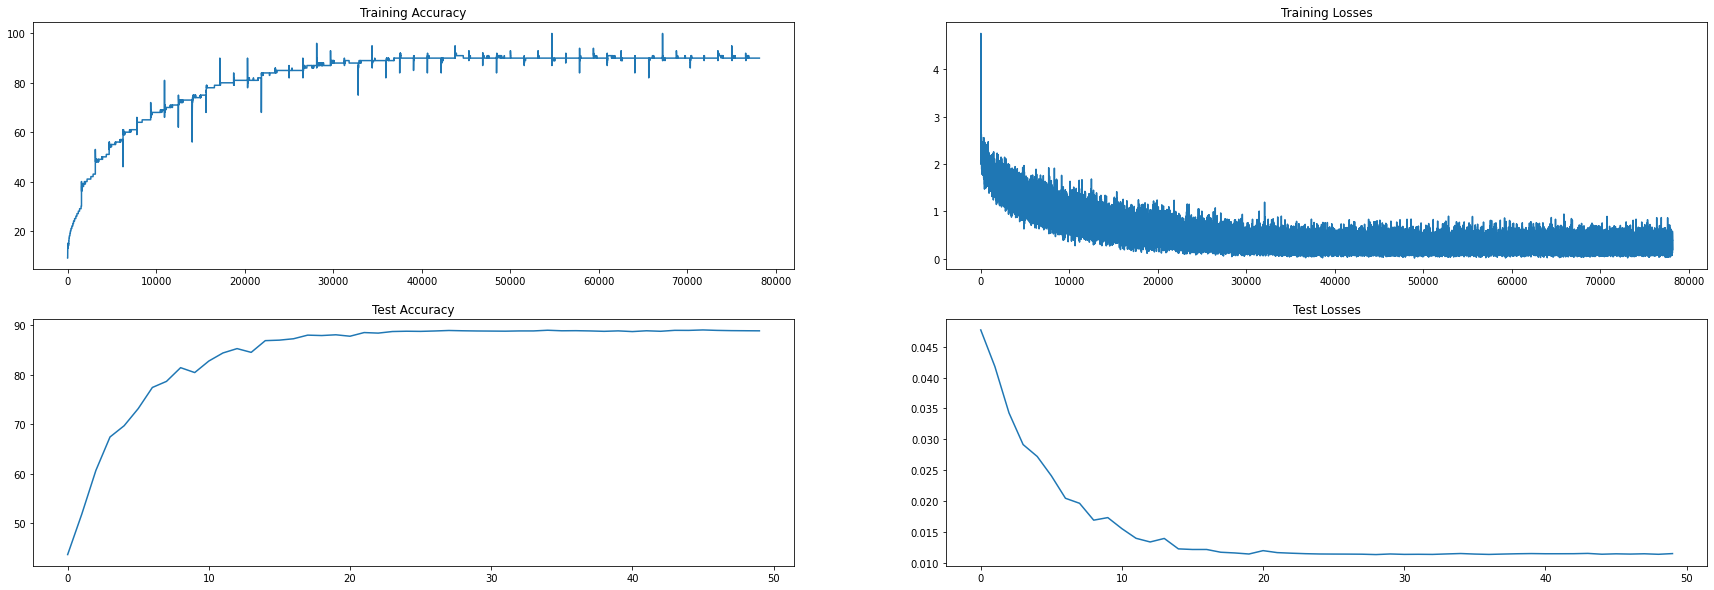

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(30,10))
print(axs)
axs[0][0].plot(train_acc, label = "train_acc")
axs[0][1].plot(train_losses, label = "train_losses")
axs[1][0].plot(test_acc, label = "test_acc")
axs[1][1].plot(test_losses, label = "test_losses")
# axs[0].legend()
axs[0][0].set_title("Training Accuracy")
axs[0][1].set_title("Training Losses")
axs[1][0].set_title("Test Accuracy")
axs[1][1].set_title("Test Losses")

In [ ]:
path = "sample_model.pth"
torch.save(model, path)

In [ ]:
# Load the model
loaded_model = torch.load('sample_model.pth')

## GradCam Integration

In [ ]:
from ezio.utils.gradcam.generate_images import gradcam_features, plot_grid

In [ ]:
## Cifar-10 classes
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
## Sample images
images, target_classes = next(iter(valid_loader))

In [ ]:
res = misclassified_images(loaded_model, device, test_loader=valid_loader)
mis_predicted_classes = torch.cat(list(map(lambda x: torch.reshape(x[0], [1, 1]), res))).cpu()
mis_target_classes = torch.cat(list(map(lambda x: torch.reshape(x[1], [1]), res))).cpu()
mis_images = torch.cat(list(map(lambda x: torch.reshape(x[2], [1, 3, 32, 32]), res))).cpu()

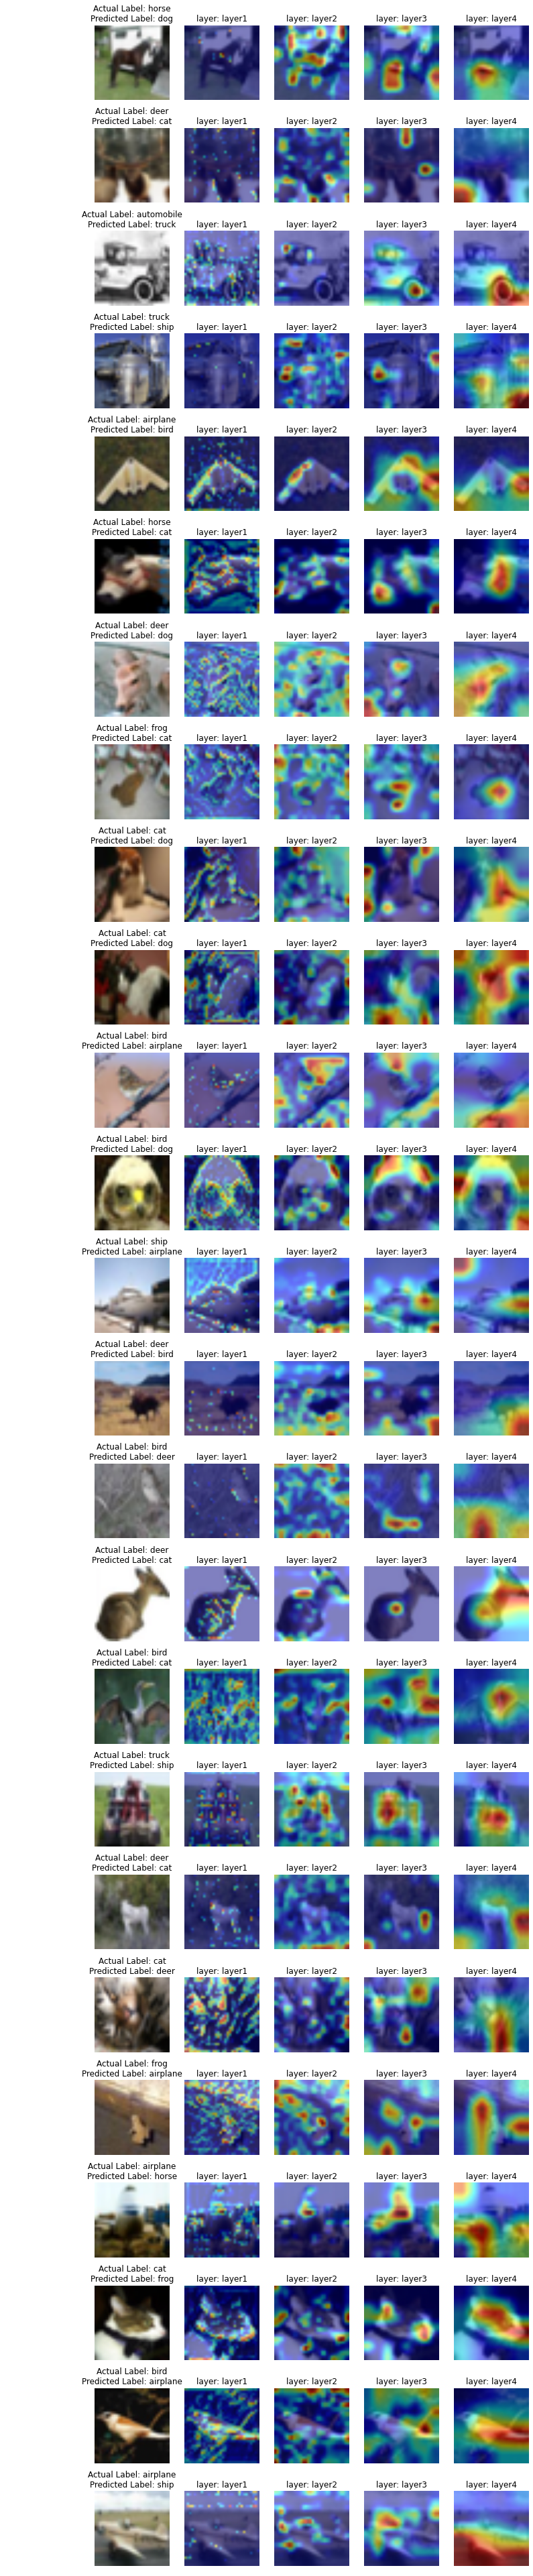

In [ ]:
## Generate grid
target_layers = ["layer1", "layer2", "layer3", "layer4"]
predicted_probs, predicted_labels, gradcam_outputs = gradcam_features(loaded_model, target_layers, mis_images[:25], mis_target_classes[:25], device)
plot_grid(gradcam_outputs, mis_images[:25], mis_target_classes[:25], mis_predicted_classes, class_names, (3, 32, 32), figsize=(14,70))